Install python packages

In [ ]:
!pip install pyspark graphframes awkward pyarrow networkx matplotlib

Initialize Spark session with graphframes 

In [1]:
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]") \
                    .appName('graphframes_pagerank') \
                    .config("spark.driver.memory","16g") \
                    .config("spark.jars.packages","graphframes:graphframes:0.8.2-spark3.2-s_2.12") \
                    .config("spark.jars.excludes","org.slf4j:slf4j-api") \
                    .getOrCreate()

:: loading settings :: url = jar:file:/opt/homebrew/lib/python3.10/site-packages/pyspark/jars/ivy-2.5.0.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /Users/sigmar/.ivy2/cache
The jars for the packages stored in: /Users/sigmar/.ivy2/jars
graphframes#graphframes added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-ae31e914-09b8-4612-bdaa-595f5a376076;1.0
	confs: [default]
	found graphframes#graphframes;0.8.2-spark3.2-s_2.12 in spark-packages
:: resolution report :: resolve 65ms :: artifacts dl 1ms
	:: modules in use:
	graphframes#graphframes;0.8.2-spark3.2-s_2.12 from spark-packages in [default]
	---------------------------------------------------------------------
	|                  |            modules            ||   artifacts   |
	|       conf       | number| search|dwnlded|evicted|| number|dwnlded|
	---------------------------------------------------------------------
	|      default     |   1   |   0   |   0   |   0   ||   1   |   0   |
	---------------------------------------------------------------------
:: retrieving :: org.apache.spark#spark-submit-parent-ae31e91

22/12/01 11:02:42 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


Load graphframes demo data, social network. Sparse.

In [2]:
from pyspark.sql.functions import col, lit, when
from pyspark.sql.types import IntegerType
from graphframes.examples import Graphs
g = Graphs(spark).friends()
g.vertices.show()
g.edges.toPandas()

/opt/homebrew/lib/python3.10/site-packages/pyspark/sql/dataframe.py:148: UserWarning: DataFrame.sql_ctx is an internal property, and will be removed in future releases. Use DataFrame.sparkSession instead.
  warnings.warn(


+---+-------+---+
| id|   name|age|
+---+-------+---+
|  a|  Alice| 34|
|  b|    Bob| 36|
|  c|Charlie| 30|
|  d|  David| 29|
|  e| Esther| 32|
|  f|  Fanny| 36|
+---+-------+---+



,src,dst,relationship
0,a,b,friend
1,b,c,follow
2,c,b,follow
3,f,c,follow
4,e,f,follow
5,e,d,friend
6,d,a,friend


Load synteny graph from Ecoli bacteria. Drop sequencing errors in resulting single gene contigs

In [3]:
root = "/Users/sigmar/Google Drive/My Drive/"
#root = "/content/drive/MyDrive/"

from graphframes import GraphFrame
vertices = spark.read.format("csv").load(root+"spark-notebooks/vert_gs.csv") \
    .withColumnRenamed("_c0","id") \
    .withColumnRenamed("_c1","name") \
    .withColumnRenamed("_c2","presentIn") \
    .withColumnRenamed("_c3","color");
edges = spark.read.format("csv").load(root+"spark-notebooks/edge_gs.csv").withColumnRenamed("_c0","src").withColumnRenamed("_c1","dst")
g = GraphFrame(vertices, edges).dropIsolatedVertices()

/opt/homebrew/lib/python3.10/site-packages/pyspark/sql/dataframe.py:148: UserWarning: DataFrame.sql_ctx is an internal property, and will be removed in future releases. Use DataFrame.sparkSession instead.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/pyspark/sql/dataframe.py:127: UserWarning: DataFrame constructor is internal. Do not directly use it.
  warnings.warn("DataFrame constructor is internal. Do not directly use it.")


In [20]:
genes = g.inDegrees.join(g.vertices)
genes.select("name","inDegree").orderBy(col("inDegree").desc()).limit(10).toPandas()

/opt/homebrew/lib/python3.10/site-packages/pyspark/sql/dataframe.py:127: UserWarning: DataFrame constructor is internal. Do not directly use it.
  warnings.warn("DataFrame constructor is internal. Do not directly use it.")


,name,inDegree
0,ABC transporter permease,78
1,O-acetylhomoserineaminocarboxypropyltransferas...,78
2,ABC transporter permease,78
3,hypothetical protein,78
4,ABC transporter substrate-binding protein,78
5,hydantoinase/oxoprolinase family protein,78
6,aminopeptidase P family protein,78
7,ABC transporter ATP-binding protein,78
8,translational GTPase TypA,78
9,EAL domain-containing protein,78


In [33]:
g.vertices.count()

2993

In [30]:
labpropres = g.labelPropagation(maxIter=20)
labelgroup = labpropres.groupBy("label")
labelcount = labelgroup.count().orderBy(col("count").desc())
labelcount.count()

/opt/homebrew/lib/python3.10/site-packages/pyspark/sql/dataframe.py:127: UserWarning: DataFrame constructor is internal. Do not directly use it.
  warnings.warn("DataFrame constructor is internal. Do not directly use it.")


328

In [32]:
labelcount.limit(15).toPandas()

,label,count
0,395136991232,192
1,558345748491,177
2,644245094404,171
3,833223655434,161
4,893353197578,71
5,532575944715,63
6,1082331758594,52
7,420906795020,42
8,996432412683,36
9,541165879305,33


In [34]:
sortlabprop = labpropres.orderBy(col("label"))
sortlabprop.where("name like '%Cas%'").toPandas()

,id,name,presentIn,color,label
0,WP_028490815.1,Cas1,5,#00aa00,438086664195
1,WP_038044033.1,Cas4,5,#00aa00,438086664195
2,WP_172957199.1,type III-B Cas10Cmr2,3,#00aa00,558345748482
3,WP_126247636.1,type III-A Cas10Csm1,2,#00aa00,558345748491
4,WP_022799288.1,endoribonuclease Cas6,7,#aa0000,558345748491
5,WP_014511087.1,type I-U Cas3,2,#00aa00,635655159814
6,extdb:aquaticus4884_000654,type I-U Cas7,2,#00aa00,635655159814
7,WP_126190901.1,Cas1,2,#00aa00,644245094404
8,BLP62_RS13400,type I-C Cas1,1,#00aa00,790273982478
9,WP_015717146.1,Cse2CasB,4,#00aa00,790273982478


In [35]:
sortlabprop.where("label = 438086664195").toPandas()

,id,name,presentIn,color,label
0,WP_014511103.1,hypothetical protein,5,#00aa00,438086664195
1,WP_028490815.1,Cas1,5,#00aa00,438086664195
2,WP_024118773.1,WYL domain-containing protein,4,#00aa00,438086664195
3,WP_126218928.1,hypothetical protein,1,#00aa00,438086664195
4,TTJL18_RS10625,WYL domain-containing protein,1,#00aa00,438086664195
5,WP_014511102.1,hypothetical protein,2,#00aa00,438086664195
6,WP_124105757.1,hypothetical protein,5,#00aa00,438086664195
7,WP_038044033.1,Cas4,5,#00aa00,438086664195


Is the graph connected. Do the bacterial strains have plasmids?

In [39]:
spark.sparkContext.setCheckpointDir("/Users/sigmar/checkpoint")
connectedComponents = g.connectedComponents()
connectedComponents.toPandas()

22/12/01 11:28:01 WARN CacheManager: Asked to cache already cached data.
22/12/01 11:28:02 WARN CacheManager: Asked to cache already cached data.
22/12/01 11:28:02 WARN CacheManager: Asked to cache already cached data.
22/12/01 11:28:02 WARN CacheManager: Asked to cache already cached data.
22/12/01 11:28:02 WARN CacheManager: Asked to cache already cached data.
22/12/01 11:28:02 WARN CacheManager: Asked to cache already cached data.
22/12/01 11:28:02 WARN CacheManager: Asked to cache already cached data.
22/12/01 11:28:02 WARN CacheManager: Asked to cache already cached data.


/opt/homebrew/lib/python3.10/site-packages/pyspark/sql/dataframe.py:127: UserWarning: DataFrame constructor is internal. Do not directly use it.
  warnings.warn("DataFrame constructor is internal. Do not directly use it.")


,id,name,presentIn,color,component
0,WP_014511309.1,ABC transporter permease,1,#00aa00,0
1,WP_014511308.1,ABC transporter permease,1,#00aa00,0
2,WP_041445125.1,hypothetical protein,1,#00aa00,0
3,WP_014511307.1,ABC transporter substrate-binding protein,1,#00aa00,0
4,WP_014511313.1,hydantoinase/oxoprolinase family protein,1,#00aa00,0
...,...,...,...,...,...
2988,CSW46_RS05590,tRNA-Met,7,#aa0000,0
2989,scotoductus2121_000106,tRNA-Lys,7,#aa0000,0
2990,BLP62_RS13090,16S ribosomal RNA,7,#aa0000,0
2991,CSW41_RS07000,tRNA-Trp,7,#aa0000,0


In [40]:
connectedComponents.orderBy(col("component").desc()).where("component>0").toPandas()

,id,name,presentIn,color,component


Number of single Gene inserts

In [44]:
triResult = g.triangleCount()

/opt/homebrew/lib/python3.10/site-packages/pyspark/sql/dataframe.py:127: UserWarning: DataFrame constructor is internal. Do not directly use it.
  warnings.warn("DataFrame constructor is internal. Do not directly use it.")


In [45]:
triResult.orderBy(col("count").desc()).where("count > 0").toPandas()

,count,id,name,presentIn,color
0,32,WP_143584933.1,transposase,5,#00aa00
1,24,WP_014632315.1,IS5-like element ISTth7 family transposase,7,#aa0000
2,18,WP_126177392.1,IS256 family transposase,7,#aa0000
3,13,extdb:filiformis947_002254,IS200/IS605 family accessory proteinTnpB-relat...,7,#aa0000
4,9,extdb:igniterrae2137_002527,IS110 family transposase,4,#00aa00
...,...,...,...,...,...
518,1,WP_015716560.1,transcriptional repressor NrdR,7,#aa0000
519,1,WP_038071875.1,hemolysin III family protein,5,#00aa00
520,1,WP_041444490.1,S41 family peptidase,7,#aa0000
521,1,WP_015716774.1,ATP synthase subunit C,7,#aa0000


Use PageRank to rank Genes

In [ ]:
prResult = g2.pageRank(tol=0.01) #.resetProbability(0.15).tol(0.01).run()

22/11/26 08:21:59 WARN BlockManager: Block rdd_112_0 already exists on this machine; not re-adding it


/opt/homebrew/lib/python3.10/site-packages/pyspark/sql/dataframe.py:127: UserWarning: DataFrame constructor is internal. Do not directly use it.
  warnings.warn("DataFrame constructor is internal. Do not directly use it.")


In [ ]:
prResult.vertices.select("name", "pagerank").orderBy(col("pagerank").desc()).toPandas()

,name,pagerank
0,transposase,14.262950
1,transposase,14.200332
2,IS256 family transposase,11.889252
3,IS200/IS605 family element transposase accesso...,6.911462
4,transposase,5.896750
...,...,...
2985,hypothetical protein,0.160372
2986,hypothetical protein,0.160372
2987,DNA adenine methylase,0.160372
2988,hypothetical protein,0.160372


In [ ]:
prResult.edges.select("src", "dst", "weight").toPandas()

,src,dst,weight
0,WP_039459555.1,FJR75_RS07735,0.250000
1,WP_126177718.1,TT_RS02875,0.333333
2,WP_203972024.1,TT_RS02875,0.333333
3,WP_011174019.1,WP_014628843.1,0.500000
4,WP_126204373.1,WP_014628843.1,0.500000
...,...,...,...
7686,WP_126178013.1,extdb:scotoductus346_000158,0.500000
7687,WP_126164537.1,extdb:scotoductus346_000604,0.500000
7688,WP_014515162.1,extdb:scotoductus346_000604,0.500000
7689,WP_143591886.1,islandicus3838_000463,0.500000


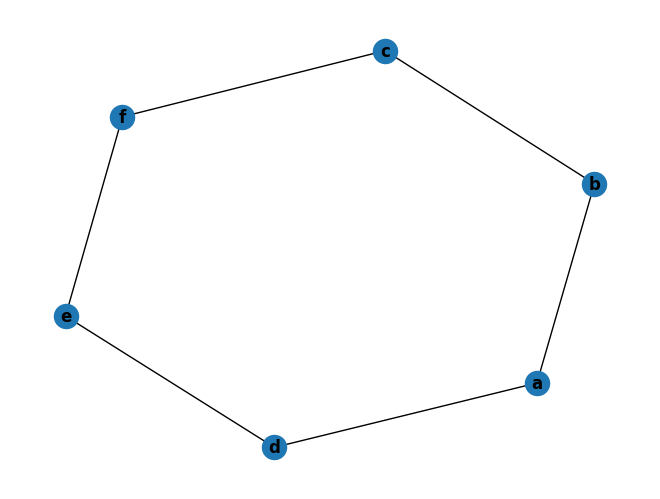

In [ ]:
import networkx as nx

def PlotGraph(edge_list):
    Gplot=nx.Graph()
    for row in edge_list.select('src','dst').take(1000):
        Gplot.add_edge(row['src'],row['dst'])

    #plt.subplot(121)
    nx.draw(Gplot, with_labels=True, font_weight='bold')

PlotGraph(g.edges)

In [ ]:
display(g2)

GraphFrame(v:[id: string, _c1: string ... 1 more field], e:[src: string, dst: string ... 1 more field])

In [ ]:
g.vertices.toPandas().to_csv("vertices.csv", index=False)
g.vertices.toPandas()

,id,name,age
0,a,Alice,34
1,b,Bob,36
2,c,Charlie,30
3,d,David,29
4,e,Esther,32
5,f,Fanny,36


In [ ]:
g.edges.toPandas().to_csv("edges.csv", index=False)
g.edges.toPandas()

,src,dst,relationship
0,a,b,friend
1,b,c,follow
2,c,b,follow
3,f,c,follow
4,e,f,follow
5,e,d,friend
6,d,a,friend


In [ ]:
motifs = g.find("(a)-[e]->(b); (b)-[e2]->(a)")
motifs.toPandas()

In [ ]:
motifs.filter("b.age > 30").toPandas()

In [ ]:
results = g.triangleCount()
results.select("id", "count").toPandas()

In [ ]:
results = g.shortestPaths(landmarks=["a", "d"])
results.select("id", "distances").toPandas()